World Coins
A collection of coin images from 32 different currencies.

In [45]:
# Seznam knihoven
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import cv2
import kaggle
import random
import concurrent.futures
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
# Stažení dat z Kaggle přes API token
kaggle.api.dataset_download_files('wanderdust/coin-images', path='./data', unzip=True)
print("Dataset byl úspěšně stažen a rozbalen do složky ./data!")

In [15]:
# Napojení dat a vytvoření cesty
data_dir_train = "data/coins/data/train/"
data_dir_val = "data/coins/data/validation/"
data_dir_test = "data/coins/data/test/"
outlier_dir = "data/coins/data/outliers"
json_path = "data/cat_to_name.json"

print(os.listdir("data/"))
print(os.path.exists("data/coins/data/train/"))
print(os.path.exists("data/coins/data/validation/"))
print(os.path.exists("data/coins/data/test/"))

['cat_to_name.json', 'coins']
True
True
True


In [4]:
# Načtení mapování kategorií
with open(json_path, "r") as f:
    class_mapping = json.load(f)

class_mapping

{'1': '1 Cent,Australian dollar,australia',
 '2': '2 Cents,Australian dollar,australia',
 '3': '5 Cents,Australian dollar,australia',
 '4': '10 Cents,Australian dollar,australia',
 '5': '20 Cents,Australian dollar,australia',
 '6': '50 Cents,Australian dollar,australia',
 '7': '1 Dollar,Australian dollar,australia',
 '8': '2 Dollars,Australian dollar,australia',
 '9': '1 Centavo,Brazilian Real,brazil',
 '10': '5 Centavos,Brazilian Real,brazil',
 '11': '10 Centavos,Brazilian Real,brazil',
 '12': '25 Centavos,Brazilian Real,brazil',
 '13': '1 Real,Brazilian Real,brazil',
 '14': '1 Penny,British Pound,united_kingdom',
 '15': '2 Pence,British Pound,united_kingdom',
 '16': '5 Pence,British Pound,united_kingdom',
 '17': '10 Pence,British Pound,united_kingdom',
 '18': '20 Pence,British Pound,united_kingdom',
 '19': '50 Pence,British Pound,united_kingdom',
 '20': '1 Pound,British Pound,united_kingdom',
 '21': '2 Pounds,British Pound,united_kingdom',
 '22': '1 Cent,Canadian Dollar,canada',
 '23

In [16]:
# Parametry pro načítání dat
img_height = 224  # Výška obrázku
img_width = 224   # Šířka obrázku
batch_size = 32   # Velikost batch

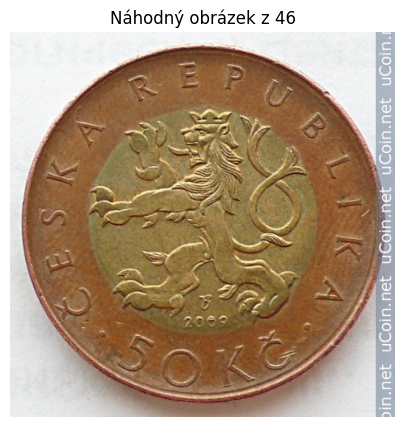

In [17]:
random_class = random.choice(os.listdir(data_dir_train))
class_path = os.path.join(data_dir_train, random_class)
random_image = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, random_image)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"Náhodný obrázek z {random_class}")
plt.axis("off")
plt.show()

In [23]:
# Funkce pro odebrání pozadí a oříznutí vodoznaku
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_right_edge(image):
    """Ořízne pravou část obrázku."""
    height, width = image.shape[:2]
    return image[:, :int(width * 0.9)]  # Oříznutí 10 % pravého okraje

def remove_background(img_path):
    """Odstraní pozadí a vodoznak pomocí OpenCV."""
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Načtení obrázku
    
    if image is None:
        print(f"Varování: Obrázek {img_path} nelze načíst.")
        return None

    # Převod na šedou škálu
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Použití prahování pro získání masky pozadí
    _, mask = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)

    # Inverze masky
    mask_inv = cv2.bitwise_not(mask)

    # Aplikace masky na obrázek (odstranění pozadí)
    result = cv2.bitwise_and(image, image, mask=mask_inv)

    return result

def preprocess_and_save_images(root_dir):
    """Předzpracuje obrázky: ořízne okraj a odstraní pozadí."""
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                if img_path.endswith(('.jpg', '.png')):
                    image = cv2.imread(img_path)  # Načtení obrázku
                    if image is None:
                        print(f"Varování: Obrázek {img_path} nelze načíst.")
                        continue
                    
                    processed_img = crop_right_edge(image)  # Oříznutí pravého okraje
                    processed_img = remove_background(img_path)  # Odstranění pozadí
                    if processed_img is not None:
                        cv2.imwrite(img_path, processed_img)  # Uložení zpět

preprocess_and_save_images(data_dir_train)
preprocess_and_save_images(data_dir_val)

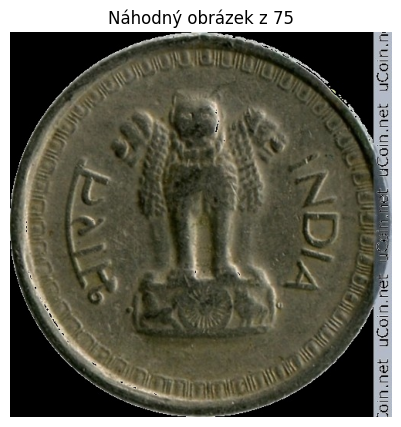

In [40]:
random_class = random.choice(os.listdir(data_dir_train))
class_path = os.path.join(data_dir_train, random_class)
random_image = random.choice(os.listdir(class_path))
image_path = os.path.join(class_path, random_image)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"Náhodný obrázek z {random_class}")
plt.axis("off")
plt.show()

In [ ]:
# Rychlejší model pro extrakci příznaků
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_extractor.predict(img_array).flatten()

def cluster_and_clean_dataset(root_dir, max_images=500):
    os.makedirs(outlier_dir, exist_ok=True)
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        outlier_category_path = os.path.join(outlier_dir, category)
        os.makedirs(outlier_category_path, exist_ok=True)
        
        if os.path.isdir(category_path):
            image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.png'))]
            if len(image_files) < 2:
                continue
            
            # Omezit počet obrázků pro rychlejší testování
            image_files = image_files[:max_images] if len(image_files) > max_images else image_files
            
            # Extrakce příznaků paralelně
            with concurrent.futures.ThreadPoolExecutor() as executor:
                features = list(executor.map(extract_features, image_files))
            
            # Rychlejší clustering s MiniBatchKMeans
            kmeans = MiniBatchKMeans(n_clusters=2, batch_size=32, random_state=42).fit(features)
            distances = np.min(kmeans.transform(features), axis=1)
            threshold = np.percentile(distances, 90)
            outlier_images = [image_files[i] for i in range(len(image_files)) if distances[i] > threshold]
            
            for img_path in outlier_images:
                os.rename(img_path, os.path.join(outlier_category_path, os.path.basename(img_path)))

# Aplikace clusteringu pro odstranění špatně zařazených obrázků
cluster_and_clean_dataset(data_dir_train)
cluster_and_clean_dataset(data_dir_val)

In [49]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 211
EPOCHS = 50

# ImageDataGenerator s odpovídajícím předzpracováním pro ResNet50
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True  # Přidáno pro lepší generalizaci rubu a líce
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Načtení datasetu
train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    data_dir_val,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Načtení předtrénovaného modelu ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Přidání nových vrstev
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Vytvoření modelu
model = Model(inputs=base_model.input, outputs=x)

# Kompilace modelu
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Trénování modelu
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

# Uložení modelu
model.save("final_resnet50_model.h5")

# Postupné rozmrznutí některých vrstev pro doladění
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Rekompilace s nižší learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Další fáze trénování
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Uložení finálního doladěného modelu
model.save("fine_tuned_resnet50_model.h5")